# Basic workflow with ART for evasion attacks, defenses and metrics

In [1]:
%matplotlib inline
import keras.backend as k
from keras.applications import vgg16, vgg19, resnet50
from keras.preprocessing import image
from keras.utils import np_utils
import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt

Using TensorFlow backend.


## Import a standard visual recognition model

Here, we will use Keras as backend and ImageNet as dataset.

In [2]:
# Load model
from keras.applications.vgg16 import VGG16, preprocess_input
from art.classifiers import KerasClassifier

model = VGG16(weights='imagenet')
classifier = KerasClassifier(clip_values=(0, 255), model=model)

Load an ImageNet example

Prediction: trench coat - confidence 0.94


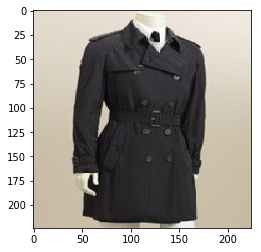

In [3]:
from os.path import join, abspath, expanduser

# Get Imagenet labels
path = expanduser('~/git/nemesis')
with open(join(path, "imagenet/labels.txt"), "r") as f_input:
    class_names = eval(f_input.read())

# Get some data
image_file = join(path,'test_api/clean100/n04479046_2998_224x224.jpg')
image_ = image.load_img(image_file, target_size=(224, 224))
img = image.img_to_array(image_)
plt.imshow(img / 255)
img = img[None, ...]

# Predict for clean image
pred = classifier.predict(img)
label = np.argmax(pred, axis=1)[0]
confidence = pred[:,label][0]
print('Prediction:', class_names[label], '- confidence {0:.2f}'.format(confidence))

## Perform evasion attack

Prediction: bulletproof vest - confidence 1.00


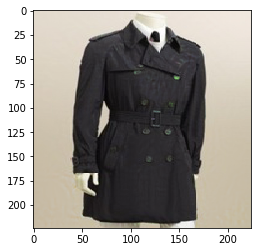

In [4]:
from art.attacks import CarliniL2Method

# Create attacker
adv = CarliniL2Method(classifier, targeted=False, max_iter=10, binary_search_steps=1, learning_rate=1e-3, initial_const=3.125)

# Generate attack image
img_adv = adv.generate(img)

# Evaluate it on model
pred_adv = model.predict(img_adv)
label_adv = np.argmax(pred_adv, axis=1)[0]
confidence_adv = pred_adv[:, label_adv][0]
print('Prediction:', class_names[label_adv], '- confidence {0:.2f}'.format(confidence_adv))
plt.imshow(img_adv[0] / 255)

## Compute attack statistics

Noise L_0 norm: 25%
Noise L_2 norm: 2%
Noise L_inf norm: 28%


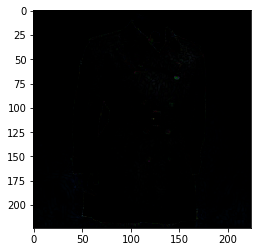

In [5]:
import numpy as np

l0 = int(99*len(np.where(np.abs(img[0] - img_adv[0])>0.5)[0]) / (224*224*3)) + 1   
l1 = int(99*np.sum(np.abs(img[0] - img_adv[0])) / np.sum(np.abs(img[0]))) + 1
l2 = int(99*np.linalg.norm(img[0] - img_adv[0]) / np.linalg.norm(img[0])) + 1 
linf = int(99*np.max(np.abs(img[0] - img_adv[0])) / 255) + 1
print('Noise L_0 norm: %d%%' % l0)
print('Noise L_2 norm: %d%%' % l2)
print('Noise L_inf norm: %d%%' % linf)
plt.imshow(np.abs(img[0] - img_adv[0]) / 255)

## Compute robustness metrics

In [6]:
from art.metrics import loss_sensitivity, clever, empirical_robustness

ls = loss_sensitivity(classifier, img, pred)
ls_adv = loss_sensitivity(classifier, img_adv, pred_adv)
er = empirical_robustness(classifier, img, 'fgsm', {})
er_adv = empirical_robustness(classifier, img_adv, 'fgsm', {})

In [7]:
from tabulate import tabulate

print(tabulate([['Minimal distortion', er, er_adv], ['Loss sensitivity', ls, ls_adv]], headers=['', 'Clean', 'Adversarial']))

                          Clean    Adversarial
------------------  -----------  -------------
Minimal distortion  0.000784317    0.00352942
Loss sensitivity    0.00501554     6.23182e-06
